<h1>California House Price Prediction</h1><br>
<list>
    <li>Download data</li>
    <li>Split into: train_set, test_set</li>
    <li>Explore</li>
    <li>Prepare</li>
</list>
<h3>-----------------------------------------------------------------</h3>

<h2>Download Data</h2>

In [1]:
from utils import HOUSING_PATH, load_housing_data
housing = load_housing_data(HOUSING_PATH)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


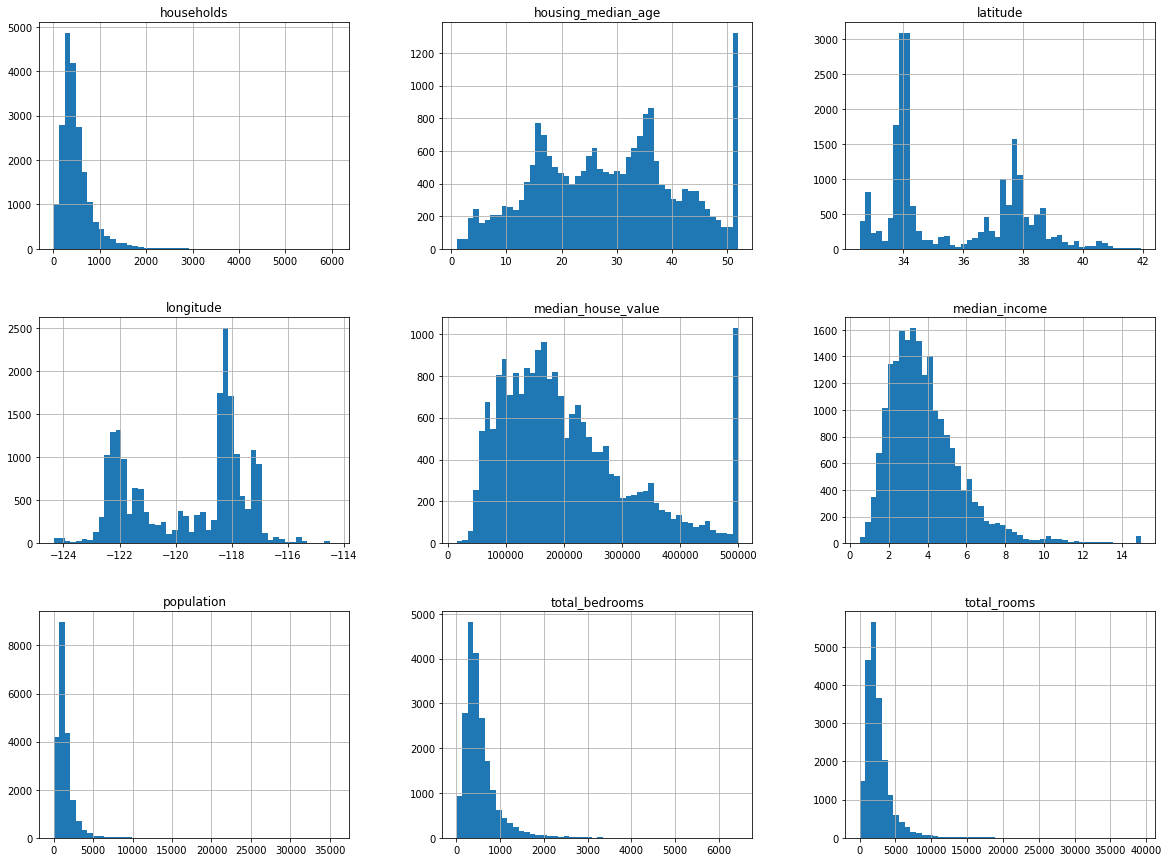

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

<h2>Split Data</h2>
Stratified on median_income

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from utils import check_split_proportions

housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

overall_split = housing["income_cat"].value_counts() / len(housing)
strat_split = strat_test_set["income_cat"].value_counts() / len(strat_test_set)
proportions = check_split_proportions(overall_split, strat_split)

# remove the temporarily created category
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
       
print(proportions)
strat_train_set.head()

      Overall  Stratified
1.0  0.039826    0.039729
2.0  0.318847    0.318798
3.0  0.350581    0.350533
4.0  0.176308    0.176357
5.0  0.114438    0.114583


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


<h2>Explore Data</h2>

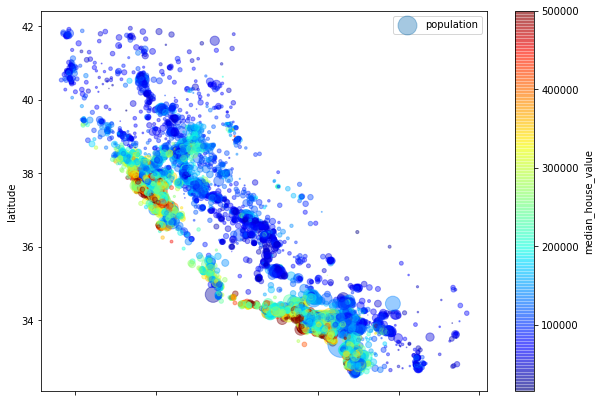

In [4]:
housing = strat_train_set.copy()
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/50, label='population', figsize=(10,7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

# s = size of the plot in proportion to population
# c = colour of plot in proportion to median_house_value

In [5]:
# Get standard (pearson) correlation coefficient of all bivariates 
corr_matrix = housing.corr(method='pearson')
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d5c46d8>,
      dtype=object)

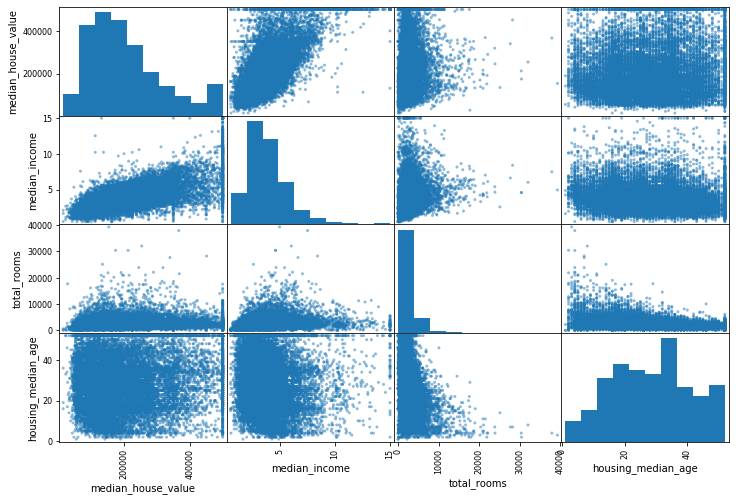

In [6]:
# Check for correlation between most promising attributes using pandas scatter plot
# which plots every numerical value against eachother
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8), diagonal='hist')

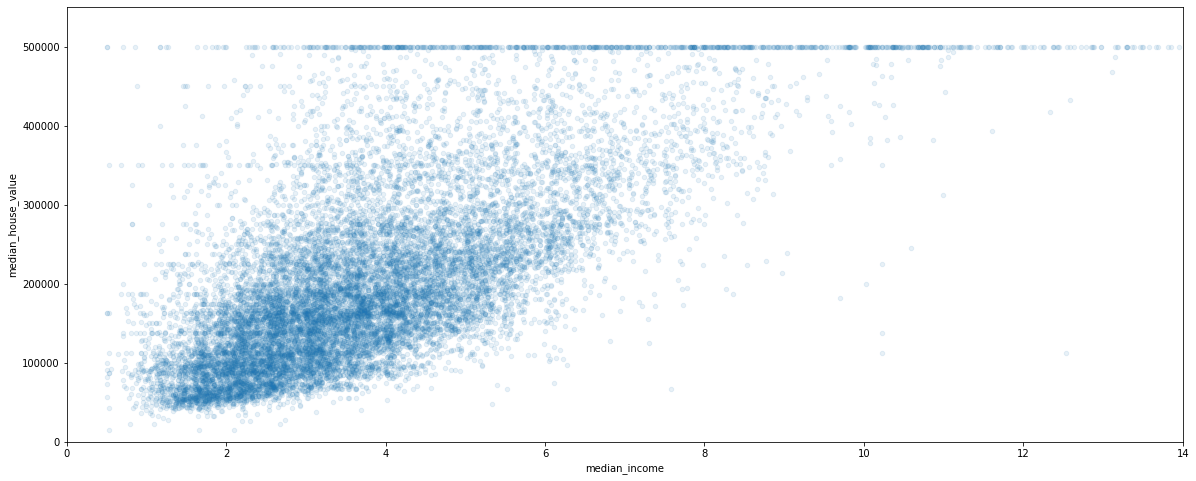

In [7]:
# Investigate median_income vs median_house_value
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(20,8),
            xlim=(0, 14), ylim=(0, 550000))

In [8]:
# Explore some combinations of attributes to create new data columns
# to potentially find new correlations
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)
# rooms_per_household and bedrooms_per_room seem relatively well correlated with median_house_price

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

<h2>Prepare Data</h2>

In [9]:
# remove target attribute from dataset
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
# handle missing numerical values
from sklearn.impute import SimpleImputer
housing_num = housing.drop('ocean_proximity', axis=1)

In [10]:
### TEST on copied housing data - just include this in pipeline
imputer = SimpleImputer(strategy='median')
#imputer.fit(housing_num)
X = imputer.fit_transform(housing_num)
print(imputer.statistics_)
print(housing_num.median().values)
### END TEST

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [11]:
# handle missing categorical values
### TEST on copied housing data - just include this in pipeline
from sklearn.preprocessing import OneHotEncoder
housing_cat = housing['ocean_proximity']
cat_encoder = OneHotEncoder(sparse=True) # change to true to ouput in sparse matrix ie less memory
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.values.reshape(-1, 1))
#print(cat_encoder.categories_)
#print(housing_cat_1hot)
# 1hot = each category either 0 or 1 where 1 means this is the categroy for this row

### END TEST

<h2>Pipeline</h2>

In [12]:
# Custom transformer to add 3 features explored earlier:
# rooms_per_household, population_per_household, bedrooms_per_room
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        # has to exist but nothing to do
        return self
    
    def transform(self, X, y=None):
        # ndarray slicing, :, rooms_ix = all rows, rooms column
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
            
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [13]:
# Custom transformer to remove non-numeric data columns
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [14]:
# Create Pipeline - calls transform
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

<h2>Train Model</h2>

In [15]:
# Try linear regressor
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
pd.DataFrame(lin_reg.predict(some_data_prepared), some_labels, columns=['Labels'])


,Labels
median_house_value,
286600.0,210644.604593
340600.0,317768.806972
196900.0,210956.433312
46300.0,59218.988868
254500.0,189747.558499


In [16]:
# Try Decision tree regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [27]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
# RMSEs
from sklearn.metrics import mean_squared_error

lin_predictions = lin_reg.predict(housing_prepared)
tree_predictions = tree_reg.predict(housing_prepared)
forest_predictions = forest_reg.predict(housing_prepared)

lin_rmse = np.sqrt(mean_squared_error(housing_labels, lin_predictions))
tree_rmse = np.sqrt(mean_squared_error(housing_labels, tree_predictions))
forest_rmse = np.sqrt(mean_squared_error(housing_labels, forest_predictions))

print(lin_rmse)
print(tree_rmse)
print(forest_rmse)

68628.19819848923
0.0
22260.428028982864


In [29]:
# Cross validation
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("\nScores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
tree_rmse_scores = np.sqrt(-tree_scores)
forest_rmse_scores = np.sqrt(-forest_scores)

for scores in lin_rmse_scores, tree_rmse_scores, forest_rmse_scores:
    display_scores(scores)


Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard Deviation:  2731.6740017983493

Scores:  [68288.15543649 65356.05645832 70844.97662886 68876.65326619
 72396.38190591 74720.19997372 70619.53644082 70753.18117457
 76781.9205288  70202.05419017]
Mean:  70883.91160038418
Standard Deviation:  3060.5364384602285

Scores:  [53072.05052904 49501.08570034 52485.70417411 55001.60547348
 52085.20693801 55628.27264044 51627.68702483 50883.51185268
 54758.64031976 52420.63253103]
Mean:  52746.43971837186
Standard Deviation:  1827.8812843178305


In [39]:
# Grid search to fine-tune hypter parameters of best model
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}    
]

#grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
#grid_search.fit(housing_prepared, housing_labels)
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(np.sqrt(-mean_score), params)

print("\n", grid_search.best_params_)

64853.045756873216 {'max_features': 2, 'n_estimators': 3}
55694.57234576791 {'max_features': 2, 'n_estimators': 10}
52867.27352699695 {'max_features': 2, 'n_estimators': 30}
60326.0324483013 {'max_features': 4, 'n_estimators': 3}
53137.68868669406 {'max_features': 4, 'n_estimators': 10}
50846.81214217485 {'max_features': 4, 'n_estimators': 30}
60385.638929061126 {'max_features': 6, 'n_estimators': 3}
52499.7658697348 {'max_features': 6, 'n_estimators': 10}
49929.78560522963 {'max_features': 6, 'n_estimators': 30}
58595.51619815584 {'max_features': 8, 'n_estimators': 3}
52681.49986790887 {'max_features': 8, 'n_estimators': 10}
50060.90483438669 {'max_features': 8, 'n_estimators': 30}
63054.87135565328 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54763.50922498086 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59754.14329430736 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52967.79303615953 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [42]:
# Find how important each feature is
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = cat_pipeline.named_steps['cat_encoder']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.318565594087651, 'median_income'),
 (0.14748246359851608, 'INLAND'),
 (0.10817040184116826, 'pop_per_hhold'),
 (0.09094472765191648, 'bedrooms_per_room'),
 (0.07778824691745158, 'longitude'),
 (0.06425333125302735, 'latitude'),
 (0.05839606927678449, 'rooms_per_hhold'),
 (0.04112995610226284, 'housing_median_age'),
 (0.018328635592102203, 'population'),
 (0.017531089661602297, 'total_bedrooms'),
 (0.016696296157021003, 'households'),
 (0.01627211662811431, 'total_rooms'),
 (0.01530043640225005, '<1H OCEAN'),
 (0.0054920459370560466, 'NEAR OCEAN'),
 (0.0035918435971543806, 'NEAR BAY'),
 (5.6745295921516315e-05, 'ISLAND')]

In [ ]:
# Create Test Set Manually - using row id as uid (better to use some feature as id)
#from zlib import crc32
#import numpy as np

# if crc hash of id column < 20% (eg ratio) of max crc hash (32 bit int)
#     return true as belongs in test set
# else:
#     return false
#def test_set_check(identifier, test_ratio):
#    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

# returns train_set and test_set, split by crc hash based on 
# proposed test_set ratio
#def split_train_test_by_id(data, test_ratio, id_column):
#    ids = data[id_column]
#    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
#    return data.loc[~in_test_set], data.loc[in_test_set]

#housing_with_id = housing.reset_index()
#train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

#print("train set = " + str(len(train_set.index)/len(housing.index)))
#print("test set = " + str(len(test_set.index)/len(housing.index)))